ESSENTIAL IMPORTS

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

In [13]:
!pip install xgboost

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

DATA LOADING

In [17]:
from google.colab import files
uploaded = files.upload()

Saving bodyPerformanceData.csv to bodyPerformanceData.csv


In [18]:
import io
df = pd.read_csv(io.BytesIO(uploaded['bodyPerformanceData.csv']))
print(df)

        age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0      27.0      M      172.3      75.24        21.3       80.0     130.0   
1      25.0      M      165.0      55.80        15.7       77.0     126.0   
2      31.0      M      179.6      78.00        20.1       92.0     152.0   
3      32.0      M      174.5      71.10        18.4       76.0     147.0   
4      28.0      M      173.8      67.70        17.1       70.0     127.0   
...     ...    ...        ...        ...         ...        ...       ...   
13388  25.0      M      172.1      71.80        16.2       74.0     141.0   
13389  21.0      M      179.7      63.90        12.1       74.0     128.0   
13390  39.0      M      177.2      80.50        20.1       78.0     132.0   
13391  64.0      F      146.1      57.70        40.4       68.0     121.0   
13392  34.0      M      164.0      66.10        19.5       82.0     150.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm cl

INITIAL INSPECTION

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [9]:
df.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


MACHINE LEARNING MODELING

In [20]:
X = df.loc[:, ['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
              'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
              'broad jump_cm']]
y = df.loc[:, 'class']

In [21]:
num_cols = X.select_dtypes(exclude =  'object').columns.tolist()
cat_cols = X.select_dtypes(include = 'object').columns.tolist()
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")

ct = ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(handle_unknown='ignore'),cat_cols),
                                     ('standardscaler', StandardScaler(), num_cols)
                                     ])

Categorical Columns: ['gender']
Numerical Columns: ['age', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.33)

In [23]:
def model_metrics(model, k = 10):

    kf = KFold(n_splits=k,
               random_state=None)

    acc_score = []
    precision = []
    recall = []
    f1_measure = []

    for train_index , test_index in kf.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)

        acc = accuracy_score(pred_values, y_test)
        prec = precision_score(pred_values, y_test, average = 'macro')
        rec = recall_score(pred_values, y_test, average = 'macro')
        f1 = f1_score(pred_values, y_test, average = 'macro')

        acc_score.append(acc)
        precision.append(prec)
        recall.append(rec)
        f1_measure.append(f1)

    accuracy = np.mean(acc_score)
    precision = np.mean(precision)
    recall = np.mean(recall)
    f1_measure = np.mean(f1_measure)

    return accuracy, precision, recall, f1_measure

LOGISTIC REGRESSION

In [24]:
classifier = LogisticRegression()
model_lr = make_pipeline(ct, classifier)

HOLDOUT METHOD

              precision    recall  f1-score   support

           A       0.68      0.74      0.71      1078
           B       0.49      0.42      0.45      1174
           C       0.49      0.53      0.51      1075
           D       0.78      0.77      0.77      1093

    accuracy                           0.61      4420
   macro avg       0.61      0.62      0.61      4420
weighted avg       0.61      0.61      0.61      4420



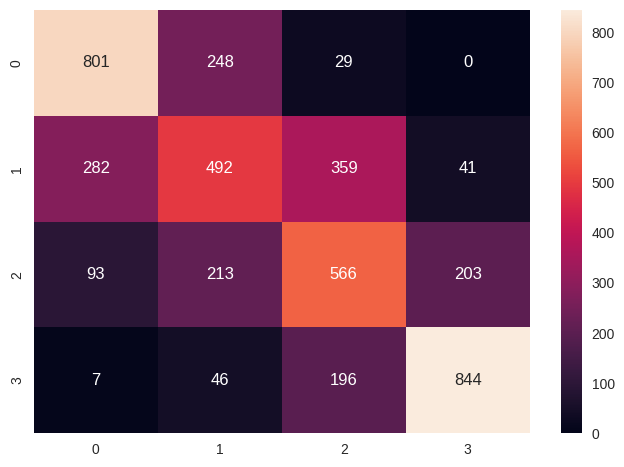

In [25]:
model_lr.fit(X_train, y_train)
model_lr_preds = model_lr.predict(X_test)
print(classification_report(y_test, model_lr_preds))

sns.heatmap(confusion_matrix(y_test, model_lr_preds),
            fmt = 'd',
            annot = True)
plt.show()

K-FOLD CROSS VALIDATION

In [26]:
accuracy, precision, recall, f1_measure = model_metrics(model_lr, k = 10)
print("Accuracy      :", round(accuracy, 2))
print()
print("Macro-Average")
print("--- Precision :", round(precision, 2))
print("--- Recall    :", round(recall, 2))
print("--- F1 Score  :", round(f1_measure, 2))

Accuracy      : 0.62

Macro-Average
--- Precision : 0.62
--- Recall    : 0.61
--- F1 Score  : 0.61


DECISION TREE

In [27]:
classifier = DecisionTreeClassifier()
model_tree = make_pipeline(ct, classifier)

HOLDOUT METHOD

              precision    recall  f1-score   support

           A       0.66      0.69      0.67      1078
           B       0.54      0.50      0.52      1174
           C       0.55      0.55      0.55      1075
           D       0.77      0.80      0.78      1093

    accuracy                           0.63      4420
   macro avg       0.63      0.63      0.63      4420
weighted avg       0.63      0.63      0.63      4420



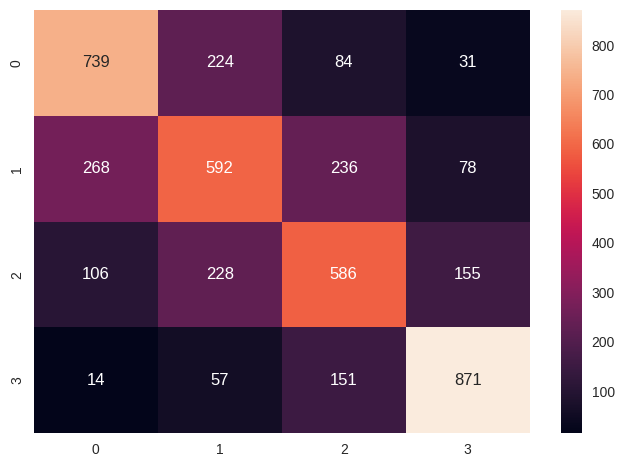

In [28]:
model_tree.fit(X_train, y_train)
model_tree_preds = model_tree.predict(X_test)
print(classification_report(y_test, model_tree_preds))

sns.heatmap(confusion_matrix(y_test, model_tree_preds),
            fmt = 'd',
            annot = True)
plt.show()

K-FOLD CROSS VALIDATION

In [19]:
accuracy, precision, recall, f1_measure = model_metrics(model_tree, k = 10)
print("Accuracy      :", round(accuracy, 2))
print()
print("Macro-Average")
print("--- Precision :", round(precision, 2))
print("--- Recall    :", round(recall, 2))
print("--- F1 Score  :", round(f1_measure, 2))

Accuracy      : 0.65

Macro-Average
--- Precision : 0.65
--- Recall    : 0.65
--- F1 Score  : 0.65


KNN

In [20]:
classifier = KNeighborsClassifier()
model_knn = make_pipeline(ct, classifier)

HOLDOUT METHOD

              precision    recall  f1-score   support

           A       0.59      0.79      0.68      1123
           B       0.40      0.45      0.42      1104
           C       0.55      0.45      0.50      1101
           D       0.90      0.63      0.74      1092

    accuracy                           0.58      4420
   macro avg       0.61      0.58      0.59      4420
weighted avg       0.61      0.58      0.59      4420



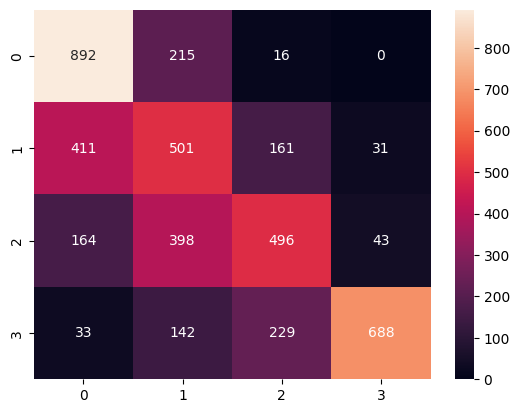

In [21]:
model_knn.fit(X_train, y_train)
model_knn_preds = model_knn.predict(X_test)
print(classification_report(y_test, model_knn_preds))
sns.heatmap(confusion_matrix(y_test, model_knn_preds),
            fmt = 'd',
            annot = True)
plt.show()

K-Fold Cross Validation

In [22]:
accuracy, precision, recall, f1_measure = model_metrics(model_knn, k = 10)
print("Accuracy      :", round(accuracy, 2))
print()
print("Macro-Average")
print("--- Precision :", round(precision, 2))
print("--- Recall    :", round(recall, 2))
print("--- F1 Score  :", round(f1_measure, 2))

Accuracy      : 0.6

Macro-Average
--- Precision : 0.6
--- Recall    : 0.62
--- F1 Score  : 0.6


Naive Bayes

In [23]:
classifier = GaussianNB()
model_naive = make_pipeline(ct, classifier)

Holdout Method

              precision    recall  f1-score   support

           A       0.57      0.75      0.65      1123
           B       0.42      0.27      0.33      1104
           C       0.47      0.46      0.47      1101
           D       0.66      0.71      0.68      1092

    accuracy                           0.55      4420
   macro avg       0.53      0.55      0.53      4420
weighted avg       0.53      0.55      0.53      4420



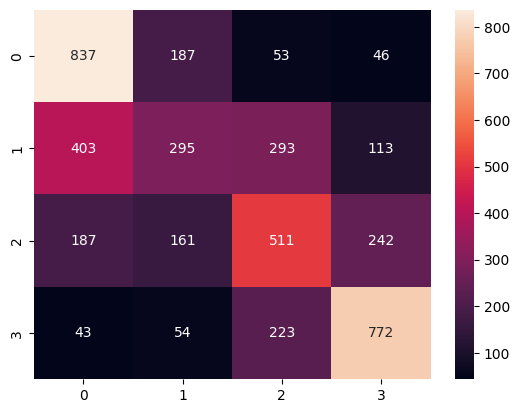

In [24]:
model_naive.fit(X_train, y_train)
model_naive_preds = model_naive.predict(X_test)
print(classification_report(y_test, model_naive_preds))
sns.heatmap(confusion_matrix(y_test, model_naive_preds),
            fmt = 'd',
            annot = True)
plt.show()

K-Fold Cross Validation

In [25]:
accuracy, precision, recall, f1_measure = model_metrics(model_naive, k = 10)
print("Accuracy      :", round(accuracy, 2))
print()
print("Macro-Average")
print("--- Precision :", round(precision, 2))
print("--- Recall    :", round(recall, 2))
print("--- F1 Score  :", round(f1_measure, 2))

Accuracy      : 0.55

Macro-Average
--- Precision : 0.55
--- Recall    : 0.54
--- F1 Score  : 0.54


Bonus Model/s

In [29]:
from pycaret.classification import *

In [ ]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 8.4 MB/s eta 0:00:00
  Using cached pyod-1.1.0.tar.gz (153 kB)
  Preparing metadata (setup.py) ... done
  Using cached category_encoders-2.6.1-py2.py3-none-any.whl (81 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.1 MB/s eta 0:00:00
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 99.3 MB/s eta 0:

In [28]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.7 MB/s

In [30]:
s = setup(df, target = 'class')

,Description,Value
0,Session id,8227
1,Target,class
2,Target type,Multiclass
3,Target mapping,"A: 0, B: 1, C: 2, D: 3"
4,Original data shape,"(13393, 12)"
5,Transformed data shape,"(13393, 12)"
6,Transformed train set shape,"(9375, 12)"
7,Transformed test set shape,"(4018, 12)"
8,Ordinal features,1
9,Numeric features,10


In [31]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7509,0.9211,0.7509,0.7567,0.7508,0.6679,0.6697,3.8980
xgboost,Extreme Gradient Boosting,0.7445,0.9177,0.7445,0.7493,0.7447,0.6594,0.6607,1.0260
rf,Random Forest Classifier,0.7294,0.9106,0.7294,0.7324,0.7287,0.6392,0.6405,1.9660
et,Extra Trees Classifier,0.7168,0.9033,0.7168,0.7178,0.7150,0.6224,0.6239,1.1600
gbc,Gradient Boosting Classifier,0.7115,0.9046,0.7115,0.7184,0.7108,0.6153,0.6177,5.8880
qda,Quadratic Discriminant Analysis,0.6467,0.8652,0.6467,0.6559,0.6483,0.5290,0.5303,0.1040
dt,Decision Tree Classifier,0.6348,0.7565,0.6348,0.6364,0.6353,0.5130,0.5132,0.1560
lr,Logistic Regression,0.6132,0.8501,0.6132,0.6105,0.6111,0.4843,0.4847,2.1940
lda,Linear Discriminant Analysis,0.6128,0.8486,0.6128,0.6179,0.6138,0.4837,0.4845,0.1240
ada,Ada Boost Classifier,0.6047,0.7303,0.6047,0.6142,0.6053,0.4729,0.4749,0.6010


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [32]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8227, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [33]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [34]:
gbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7441,0.9130,0.7441,0.7505,0.7445,0.6588,0.6605
1,0.7377,0.9175,0.7377,0.7418,0.7367,0.6503,0.6521
2,0.7708,0.9302,0.7708,0.7742,0.7702,0.6944,0.6958
3,0.7367,0.9172,0.7367,0.7418,0.7365,0.6489,0.6506
4,0.7559,0.9192,0.7559,0.7625,0.7573,0.6745,0.6756
5,0.7556,0.9221,0.7556,0.7606,0.7535,0.6741,0.6771
6,0.7524,0.9254,0.7524,0.7584,0.7532,0.6699,0.6711
7,0.7631,0.9280,0.7631,0.7689,0.7631,0.6841,0.6859
8,0.7385,0.9144,0.7385,0.7464,0.7378,0.6514,0.6544


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(gbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1473, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


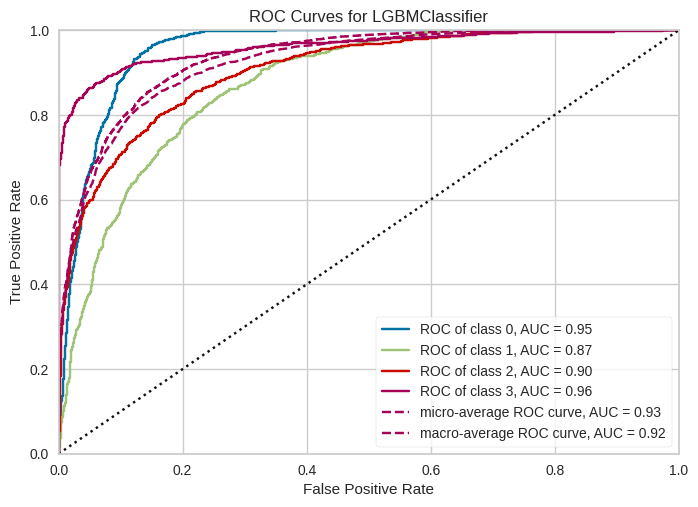

In [ ]:
plot_model(gbm, plot = 'auc')

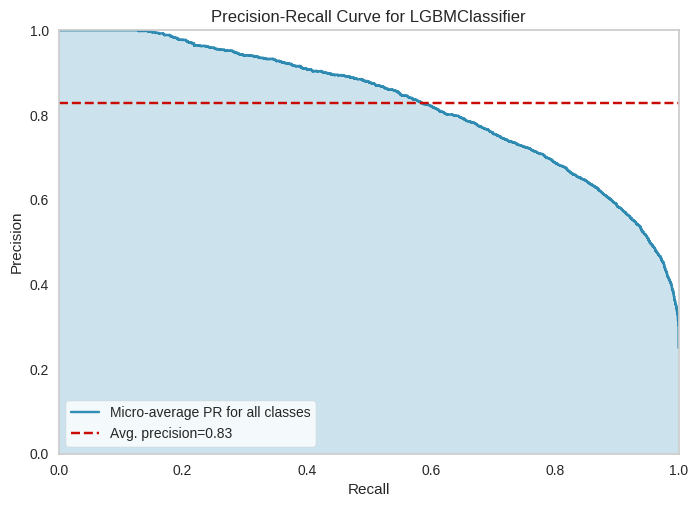

In [ ]:
plot_model(gbm, plot = 'pr')

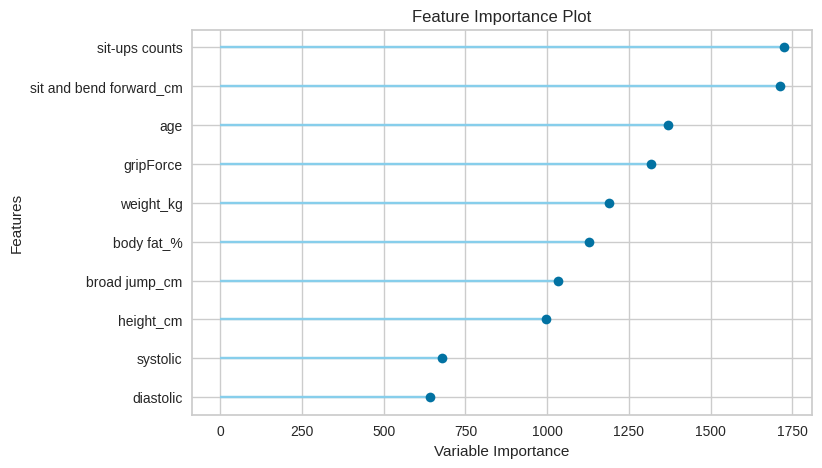

In [ ]:
plot_model(gbm, plot='feature')

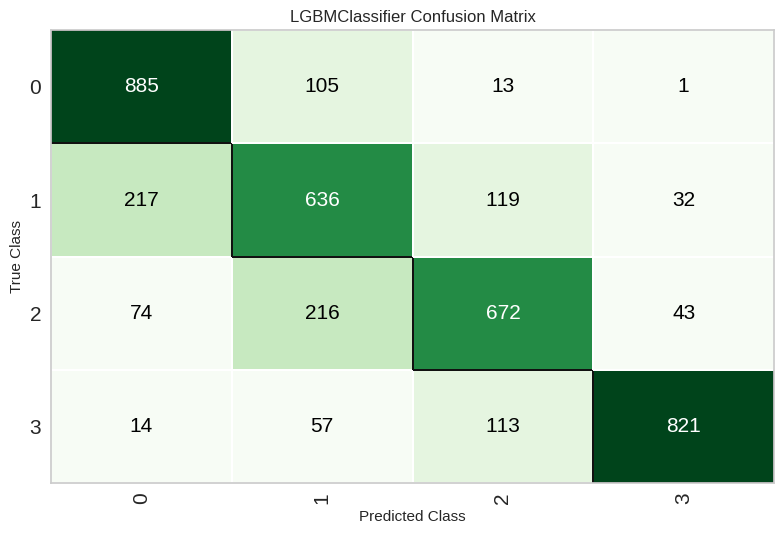

In [ ]:
plot_model(gbm, plot = 'confusion_matrix')

In [36]:
evaluate_model(gbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [37]:
predict_model(gbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7623,0.9275,0.7623,0.7685,0.7625,0.6831,0.6848


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,prediction_label,prediction_score
7235,27.0,M,174.600006,66.300003,13.300000,93.0,147.0,58.599998,17.000000,53.0,244.0,A,A,0.8370
7528,21.0,M,173.699997,79.500000,18.299999,92.0,148.0,42.900002,22.100000,63.0,209.0,B,C,0.4858
10686,50.0,M,167.199997,67.300003,16.100000,83.0,138.0,50.599998,21.200001,39.0,210.0,B,B,0.5284
12680,47.0,M,176.699997,72.300003,13.800000,91.0,128.0,44.299999,8.700000,35.0,216.0,C,C,0.9058
19,21.0,F,162.699997,47.200001,18.900000,78.0,133.0,25.400000,20.500000,36.0,137.0,B,A,0.4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,23.0,M,165.699997,66.300003,27.600000,69.0,113.0,30.299999,7.600000,48.0,162.0,D,D,0.5661
12730,56.0,F,163.199997,55.299999,20.200001,80.0,159.0,25.299999,22.500000,18.0,154.0,B,A,0.5461
10743,53.0,M,175.500000,81.000000,30.299999,93.0,145.0,39.900002,12.000000,21.0,180.0,D,D,0.9851
3670,26.0,M,176.000000,70.599998,20.799999,62.0,114.0,41.200001,16.299999,57.0,228.0,A,A,0.6060
